In [1]:
# we tried on 3 different labels to see how the logistic regression holds up, probably not well
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

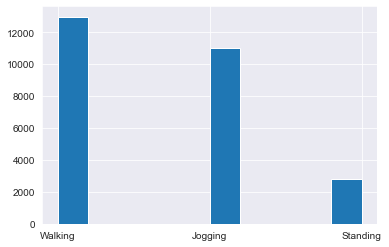

       user  activity        timestamp  x-axis  y-axis  z-axis
53503     3         1  100832351478000    2.87   18.81   -0.89
53504     3         1  100832391547000   -0.38    8.24   -1.27
53505     3         1  100832431556000    1.33    7.16   -1.95
53506     3         1  100832471839000    4.06    9.66   -1.84
53507     3         1  100832551551000    1.69    6.55   -0.11
[[ 3.00000000e+00  1.00000000e+00  1.00832351e+14  2.87000000e+00
   1.88100000e+01 -8.90000000e-01]
 [ 3.00000000e+00  1.00000000e+00  1.00832392e+14 -3.80000000e-01
   8.24000000e+00 -1.27000000e+00]
 [ 3.00000000e+00  1.00000000e+00  1.00832432e+14  1.33000000e+00
   7.16000000e+00 -1.95000000e+00]
 ...
 [ 3.00000000e+00  0.00000000e+00  1.02680782e+14 -1.12000000e+00
   9.43000000e+00 -3.80000000e-01]
 [ 3.00000000e+00  0.00000000e+00  1.02680822e+14 -9.50000000e-01
   9.43000000e+00 -3.80000000e-01]
 [ 3.00000000e+00  0.00000000e+00  1.02680861e+14 -1.18000000e+00
   9.43000000e+00 -2.70000000e-01]]
(26812, 3)

C:\Users\Florin Mazilu\AppData\Local\Temp\ipykernel_5424\143990698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['activity'] = new_df['activity'].map(activity_map)


In [2]:
df = pd.read_csv('time_series_data_human_activities.csv')
activity_map = {'Standing': 0, 'Walking': 1, 'Jogging': 2}

# select only one person and two activities i.e. Standing and walking
new_df = df[(df['user']==3) & ((df['activity']=='Standing') | (df['activity']=='Walking') | (df['activity']=='Jogging'))]
new_df['activity'].hist()
plt.show()
# one-hot encoding
# one_hot = pd.get_dummies(new_df['activity'])
# new_df = new_df.drop('activity', axis=1)
# new_df = pd.concat([new_df, one_hot], axis=1)

new_df['activity'] = new_df['activity'].map(activity_map)

print(new_df.head())

values = new_df.to_numpy()
print(values)

X = values[:, -3:]
y = values[:, 1].astype("int")
print(X.shape, y.shape)
# print(set(y))

In [3]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [4]:
train_perc = 0.7 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # we also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 18768
num test: 8044


In [5]:
def model(X, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat),
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat),
                                            5.*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coeffcients

    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)

    return y

In [6]:
n_cat = 3
# Prepare data for Pyro
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
print(y_train.shape)

torch.Size([18768])


In [7]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 40000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 85466.0
[1000] ELBO: 39496.7
[2000] ELBO: 18974.4
[3000] ELBO: 14218.7
[4000] ELBO: 14200.2
[5000] ELBO: 14191.3
[6000] ELBO: 14185.6
[7000] ELBO: 14189.3
[8000] ELBO: 14187.1
[9000] ELBO: 14185.7
[10000] ELBO: 14186.8
[11000] ELBO: 14185.8
[12000] ELBO: 14187.4
[13000] ELBO: 14190.0
[14000] ELBO: 14183.7
[15000] ELBO: 14182.9
[16000] ELBO: 14187.6
[17000] ELBO: 14184.6
[18000] ELBO: 14180.7
[19000] ELBO: 14185.3
[20000] ELBO: 14185.9
[21000] ELBO: 14181.6
[22000] ELBO: 14182.1
[23000] ELBO: 14183.2
[24000] ELBO: 14185.9
[25000] ELBO: 14187.0
[26000] ELBO: 14183.9
[27000] ELBO: 14183.6
[28000] ELBO: 14182.8
[29000] ELBO: 14185.3
[30000] ELBO: 14180.4
[31000] ELBO: 14187.0
[32000] ELBO: 14182.5
[33000] ELBO: 14183.0
[34000] ELBO: 14182.6
[35000] ELBO: 14185.4
[36000] ELBO: 14179.8
[37000] ELBO: 14182.0
[38000] ELBO: 14184.9
[39000] ELBO: 14185.1


In [8]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", 'beta'))
samples = predictive(X_train, n_cat, y_train)

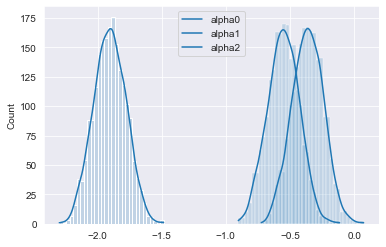

In [9]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:, c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

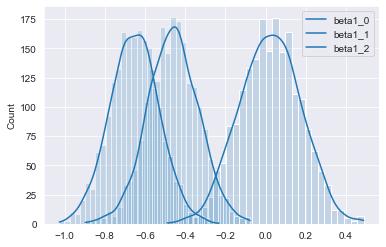

In [10]:
samples_beta = samples['beta'].detach().squeeze()
for d in range(X.shape[1]):
    sns.histplot(samples_beta[:,d,0], kde=True, alpha=0.2)
plt.legend(["beta1_%d" % d for d in range(X.shape[1])])
plt.show()

In [15]:
alpha_hat = samples_alpha.mean(axis=0).numpy()
beta_hat = samples_beta.mean(axis=0).numpy()

# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1)
print(set(y_hat))

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))
# For 3 labels the accuracy drops significantly to 66.5%

{0, 1, 2}
Accuracy: 0.6658378915962208


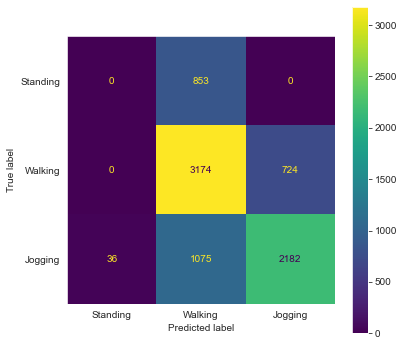

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#this section plots confusion matrix and prints testing accuracy
fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
ls = ['Standing', 'Walking', 'Jogging']
cm = confusion_matrix(y_test, y_hat, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(cm, display_labels=ls).plot(ax=ax)